In [3]:
import csv
import pandas as pd
import numpy as np
import os
import random as rd
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import wordcloud
import community
import math
import powerlaw
import urllib.request
import json
import re
import operator
from scipy import stats
from fa2 import ForceAtlas2

# Data

In [4]:
# Loading data
marvel_data = pd.read_csv("marvel.csv")
dc_data = pd.read_csv("dc.csv")

In [5]:
# Preparing data in dictionary

# For Marvel
marvel_dict = dict.fromkeys(list(marvel_data['CharacterName']),0)
marvel_entries_to_remove = []
for name in marvel_dict.keys():
    wikilink = marvel_data.loc[marvel_data['CharacterName'] == name, 'WikiLink'].item()
    if wikilink == wikilink:
        links = re.findall(r'((?:[^\\|]+|\\\|?)+)',wikilink)
        marvel_dict[name] = links
    else:
        # Wikilink is NaN and character is removed
        marvel_entries_to_remove.append(name)

# removing characters with no Wiki Link
for name in marvel_entries_to_remove:
    marvel_dict.pop(name, None)

# For DC
dc_dict = dict.fromkeys(list(dc_data['CharacterName']),0)
dc_entries_to_remove = []
for name in dc_dict.keys():
    wikilink = dc_data.loc[dc_data['CharacterName'] == name, 'WikiLink'].item()
    if wikilink == wikilink:
        links = re.findall(r'((?:[^\\|]+|\\\|?)+)',wikilink)
        dc_dict[name] = links
    else:
        # Wikilink is NaN and character is removed
        dc_entries_to_remove.append(name)

# removing characters with no Wiki Link  
for name in dc_entries_to_remove:
    dc_dict.pop(name, None)

    
inv_marvel_dict = {value: key for key in marvel_dict for value in marvel_dict[key]}
inv_dc_dict = {value: key for key in dc_dict for value in dc_dict[key]}

In [6]:
# Listing dictionaries
marvel_path = "data/marvel/"
dc_path = "data/dc/"

# Listing all files in the directories
marvel_dir_list = os.listdir(marvel_path)
dc_dir_list = os.listdir(dc_path)

# removing saved ipynb
marvel_dir_list.pop(0);
dc_dir_list.pop(0);

In [7]:
def matchPat(path, file):
    # For extracting links in the files
    pat = r'\[\[(.*?)(?:\|.*?)?\]\]'
    f = open(path+file,'r')
    str = f.read()
    match = re.findall(pat, str)
    return match

def graphCreator(DG, path, char_dict, dir_list, universe):
    # Creating directed network
    for character, links in char_dict.items():
        DG.add_nodes_from([(character, {'Universe' : universe})])
        for link in links:
            if link+'.txt' in dir_list:
                match = matchPat(path, link+'.txt')
            
                for hero in match:
                    if hero in inv_marvel_dict.keys():
                        DG.add_nodes_from([(inv_marvel_dict[hero], {'Universe' : 'Marvel'})])
                        DG.add_edge(character, inv_marvel_dict[hero])

                    elif hero in inv_dc_dict.keys():
                        DG.add_nodes_from([(inv_dc_dict[hero], {'Universe' : 'DC'})])
                        DG.add_edge(character, inv_dc_dict[hero])

In [8]:
# Constructing the network first adding Marvel and then DC characters
DG = nx.DiGraph()        
graphCreator(DG, marvel_path, marvel_dict, marvel_dir_list, 'Marvel')
graphCreator(DG, dc_path, dc_dict, dc_dir_list, 'DC')

In [9]:
# Number of links between Marvel and DC
count = 0
for a,b in DG.edges():
    if DG.nodes[a]['Universe'] != DG.nodes[b]['Universe']:
        count = count+1
print(f'Number of links between Marvel and DC: {count}')

Number of links between Marvel and DC: 1068


# Basic Stats

**Write a short paragraph describing the network.** 

**The paragraph should contain the following information**
- **The number of nodes and links**

In [10]:
print(f'Number of nodes before removing non connected nodes: {DG.number_of_nodes()}')

# Removing nodes with no in or out degree
removes = [a for a, b in DG.degree() if b == 0]
DG.remove_nodes_from(removes)
print(f'Number of nodes after removing non connected nodes: {DG.number_of_nodes()}')

print(f'Number of edges: {DG.number_of_edges()}')


Number of nodes before removing non connected nodes: 2276
Number of nodes after removing non connected nodes: 2030
Number of edges: 26194


- **The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.**

The requested values are calculated for the in- and out-degrees:

In [11]:
in_degrees = sorted((d for n, d in DG.in_degree()), reverse=False)
out_degrees = sorted((d for n, d in DG.out_degree()), reverse=True)

print(f'in-degree stats: \nMean: {np.mean(in_degrees)} \nMedian: {np.median(in_degrees)}   \nMode: {stats.mode(in_degrees)} \nMinimum:  {np.min(in_degrees)} \nMaximum: {np.max(in_degrees)} \n')

print(f'out-degree stats: \nMean: {np.mean(out_degrees)} \nMedian: {np.median(out_degrees)}   \nMode: {stats.mode(out_degrees)} \nMinimum:  {np.min(out_degrees)} \nMaximum: {np.max(out_degrees)}')

in-degree stats: 
Mean: 12.903448275862068 
Median: 5.0   
Mode: ModeResult(mode=array([1]), count=array([243])) 
Minimum:  0 
Maximum: 426 

out-degree stats: 
Mean: 12.903448275862068 
Median: 8.0   
Mode: ModeResult(mode=array([0]), count=array([396])) 
Minimum:  0 
Maximum: 114


C:\Users\guzma\AppData\Local\Temp\ipykernel_21680\3606209272.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'in-degree stats: \nMean: {np.mean(in_degrees)} \nMedian: {np.median(in_degrees)}   \nMode: {stats.mode(in_degrees)} \nMinimum:  {np.min(in_degrees)} \nMaximum: {np.max(in_degrees)} \n')
C:\Users\guzma\AppData\Local\Temp\ipykernel_21680\3606209272.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` ov

**We also want the degree distributions and a plot of the network**

- **Create and visualize in- and out-going degree distributions as described in Lecture 4. Think about which axes you should use - loglog is great for power-law distributions, but not necessarily for Poisson-like degree distributions.**
- **Estimate, report, and reflect on the slope and starting value of the incoming degree distribtion's power law using the tools described in Lecture 5 - and display the fit on top of your incoming degree-distribution plot.**

The in- and out-degree sequence is binned and plotted. The in degree is plotted with a log-log plot while a normal plot is used for the out-degree: 

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
The slope of the in degree distribution when fitted with a power law: 2.496772300182802


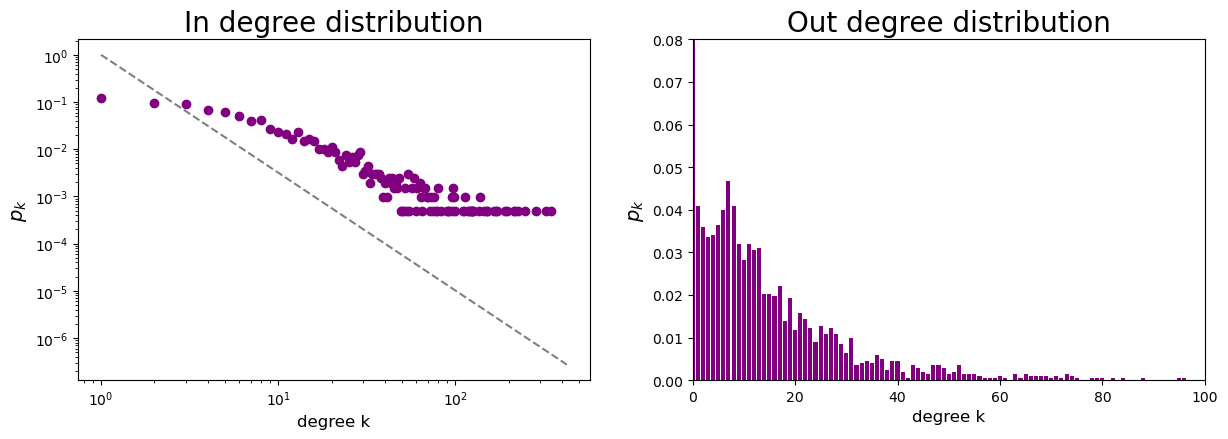

In [12]:
# Binning the degree distribution
bins_in_degrees = np.arange(np.min(in_degrees),np.max(in_degrees),1)
freq_in_degrees, hist_in_degrees = np.histogram(in_degrees, bins = bins_in_degrees);
bins_out_degrees = np.arange(np.min(out_degrees),np.max(out_degrees),1)
freq_out_degrees, hist_out_degrees = np.histogram(out_degrees, bins = bins_out_degrees);

p_k_in = [i/np.sum(freq_in_degrees) for i in freq_in_degrees]
p_k_out = [i/np.sum(freq_out_degrees) for i in freq_out_degrees]


# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('In degree distribution', fontsize = 20)
ax1.set_xlabel('degree k', fontsize = 12)
ax1.set_ylabel("$p_{k}$", fontsize = 14)
#ax1.set_xlim(0,100)
ax1.set_xscale("log");
ax1.set_yscale("log");
#ax1.scatter(*np.unique(in_degrees, return_counts=True), color = 'purple');
#ax1.scatter(hist_in_degrees[:-1], freq_in_degrees, color = 'purple');
ax1.scatter(hist_in_degrees[:-1], p_k_in, color = 'purple');

ax2.set_title('Out degree distribution', fontsize = 20)
ax2.set_xlabel('degree k', fontsize = 12)
ax2.set_ylabel('$p_{k}$', fontsize = 14)
ax2.set_xlim(0,100)
ax2.set_ylim(0,0.08)
#ax2.bar(*np.unique(out_degrees, return_counts=True), color = 'purple');
#ax2.bar(hist_out_degrees[:-1], freq_out_degrees, color = 'purple');
ax2.bar(hist_out_degrees[:-1], p_k_out, color = 'purple');

plt.subplots_adjust(wspace = 0.2)



fit = powerlaw.Fit(in_degrees)
gamma = fit.alpha
print(f'The slope of the in degree distribution when fitted with a power law: {gamma}')
powerlaw_fit = [d**(-gamma) for d in hist_in_degrees[1:]]
ax1.plot(hist_in_degrees[1:], powerlaw_fit, c = 'grey', linestyle='dashed');

#ax1.fit.power_law.plot_pdf()
#fit.plot_pdf( color= 'b')

A power law with $\gamma = 2.5$ is fitted to the data. The value is found with the powerlaw package. When analysing the in degree plot we see that the power law doesn't follow the data perfectly. However, it does have some powerlaw like features meaning that the network does have some scale free similarities.

Worth noting is that the out degree distribution does not follow a power law. It seems to be almost Poisson like indicating that the out degree is random. This makes sense since the amount of outgoing links from a characters' WikiPage doesn't indicate how popular a character is but rather how long the page is. 

The characters with the most ingoing and outgoing links are found from the degrees. The found characters are some of the main characters in the universes as expected:

In [13]:
marvel_char = [x for x,y in DG.nodes(data=True) if y['Universe']=='Marvel']
dc_char = [x for x,y in DG.nodes(data=True) if y['Universe']=='DC']

top_in_degrees = sorted(DG.in_degree(), key = operator.itemgetter(1,0), reverse = True)
top_out_degrees = sorted(DG.out_degree(), key = operator.itemgetter(1,0), reverse = True)

print(f'Top 10 in_degree:')
for name, count in top_in_degrees[:10]:
    print(f"{name :<25}: {count}")
    
print(f'\nTop 10 out_degree:')
for name, count in top_out_degrees[:10]:
    print(f"{name:<25}: {count}")


Top 10 in_degree:
Man-Spider               : 426
Captain America          : 347
Iron Man                 : 325
Hulk                     : 285
Wolverine                : 246
Thor                     : 226
Batman                   : 216
Superman                 : 213
Doctor Doom              : 196
Doctor Strange           : 191

Top 10 out_degree:
Wolverine                : 114
Iron Man                 : 107
Captain America          : 102
Norman Osborn            : 96
Psylocke (Betsy Braddock): 95
Cyclops                  : 88
Kraven the Hunter        : 84
Hawkeye                  : 82
Doctor Octopus           : 80
Spider-Ham               : 79


- **Plot the network using the Force Atlas algorithm as described in Lecture 5.**

We plot the network using the Force Atlas algorithm. We assign each node a color according to its universe (red: Marvel, black: DC) and color the edges orange, yellow or green depending on if it is a link between two Marvel character, two DC character or a Marvel and a DC character.

In [14]:
#Extract largest component
nodes = max(nx.weakly_connected_components(DG), key=len)
GCC = DG.subgraph(nodes).copy()

# Convert to undirected graph for plotting
UGCC = GCC.to_undirected()

In [15]:
# Assigning node colors and sizes based on universe and degree
node_color = []
for node, attribute in UGCC.nodes(data=True):
    if attribute['Universe'] == 'Marvel':
        node_color.append('red')
    else:
        node_color.append('black')
#print(dict(UGCC.degree).values())

edge_color = []
for n1, n2 in UGCC.edges():
    uni1 = UGCC.nodes[n1]['Universe']
    uni2 = UGCC.nodes[n2]['Universe']
    if uni1 == 'Marvel' and uni2 == 'Marvel':
        edge_color.append('orange')
    elif uni1 != uni2:
        edge_color.append('green')
    else:
        edge_color.append('yellow')
        
d = dict(UGCC.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

In [16]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UGCC, pos=None, iterations=500);

100%|██████████| 500/500 [00:35<00:00, 14.08it/s]

BarnesHut Approximation  took  5.10  seconds
Repulsion forces  took  29.26  seconds
Gravitational forces  took  0.08  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.38  seconds


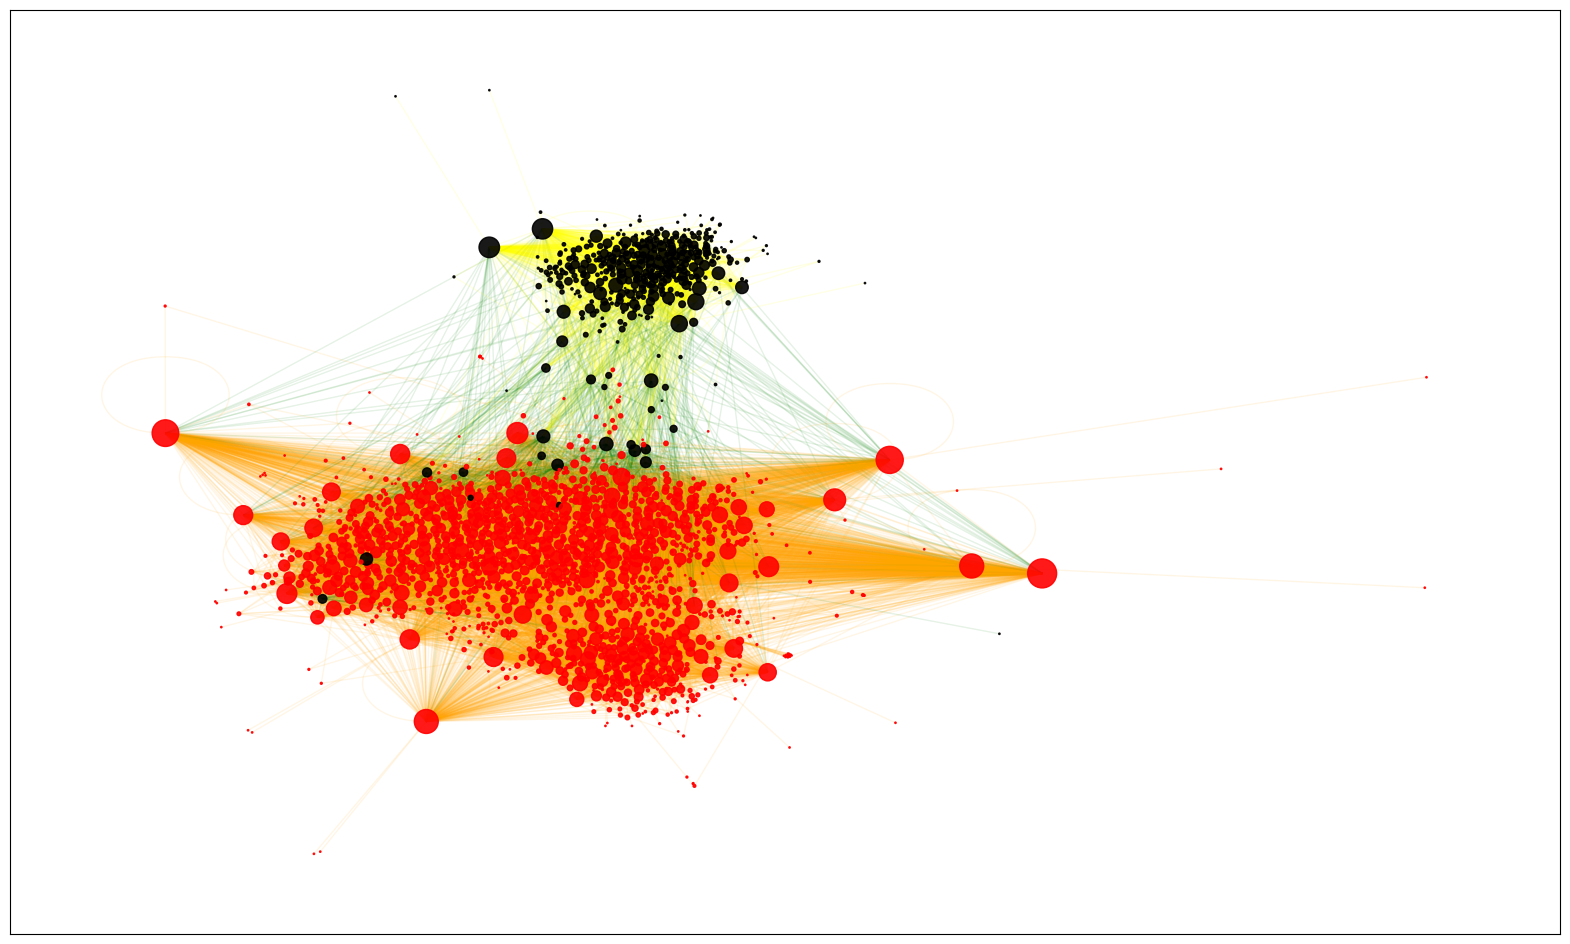

In [17]:
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(UGCC, pos = positions, node_size=node_size, node_color=node_color, alpha=0.9);
nx.draw_networkx_edges(UGCC, pos = positions, edge_color=edge_color, alpha=0.1);
plt.show()

The graph above shows us that Not only are there more marvel characters, but that marvel characters are in a more diverse "universe", meaning that more characters interact with one another. Another interesting factor we find is that there are many more marvel characers who only have one conection, but you cannot see any with 0 conections. DC characters on the other hand are shown to either be in the core with more connections, or have 0 connections.

We notice that the Marvel network seems to almost be split in two communities. We will analyse this phenomenom in the following section. 

# Communities

- **Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.**

- **Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.**

**Write a paragraph about your work to identify the communities. The paragraph should include**

- **Information about the algorithm you used to find communities.**
- **The value of modularity for your network.**
- **The number of communities and their sizes (in terms of number of nodes).**

It has been decided to only do the community identification process for one of the universes - the Marvel universe.
The Louvain-algorithm has been used to find the communities, which uses modularity as the optimisation parameter (for measuring the strength of a given partition).

In [18]:
# Using the marvel network
UGCC = UGCC
marvel_char = marvel_char
marvel_network = UGCC.subgraph(marvel_char).copy()
nodes = max(nx.connected_components(marvel_network), key=len)
marvel_network = marvel_network.subgraph(nodes).copy()

# Compute the best partition using Louvain-algorithm
partition = community.best_partition(marvel_network, random_state = 1, randomize = False)
node_color = (list(partition.values()))

To calculate the modularity $M$ of this partition equation 9.12 from Network Science is used:

\begin{equation}
M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L} \right)^2 \right]
\end{equation}

Where $L$ is the total number of links in the Marvel network $L_c$ and $k_c$ is the number of links and total degree of community c in the given partition.

In [19]:
# calculating the modularity for the found partition
L_marvel = marvel_network.number_of_edges()
M = 0
community_number_of_nodes = []
vals = list(partition.values())
for i in set(partition.values()):
    cur_nodes = [x for num,x in enumerate(marvel_network.nodes(data=True)) if vals[num] == i]
    cur_names = [x for x,y in cur_nodes]
    cur_network = marvel_network.subgraph(cur_names).copy()
    cur_L = cur_network.number_of_edges()
    cur_k = sum([val for name,val in cur_network.degree])
    M = M + (cur_L/L_marvel - (cur_k/(2*L_marvel))**2)
    community_number_of_nodes.append(cur_network.number_of_nodes())

print(f'Modularity of the partition found with Louvain-algorithm: {M}\n')
print(f'Number of communities found with Louvain-algorithm: {len(set(partition.values()))}\n')

print(f'Number of nodes in communities are: {community_number_of_nodes}')

Modularity of the partition found with Louvain-algorithm: 0.5098878356679976

Number of communities found with Louvain-algorithm: 13

Number of nodes in communities are: [350, 4, 4, 336, 386, 89, 8, 40, 15, 11, 268, 11, 58]


A modularity value of $M = 0.52$ does indeed indicate that the partition is good according to the Network Science book. However, some of the communities only contain very few nodes, which might indicate problems. 

The network is visualised with the Force Atlas algorithm, where each node is given a color based on its community

In [20]:
positions = forceatlas2.forceatlas2_networkx_layout(marvel_network, pos=None, iterations=500);

100%|██████████| 500/500 [00:24<00:00, 20.26it/s]

BarnesHut Approximation  took  3.12  seconds
Repulsion forces  took  20.78  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.27  seconds


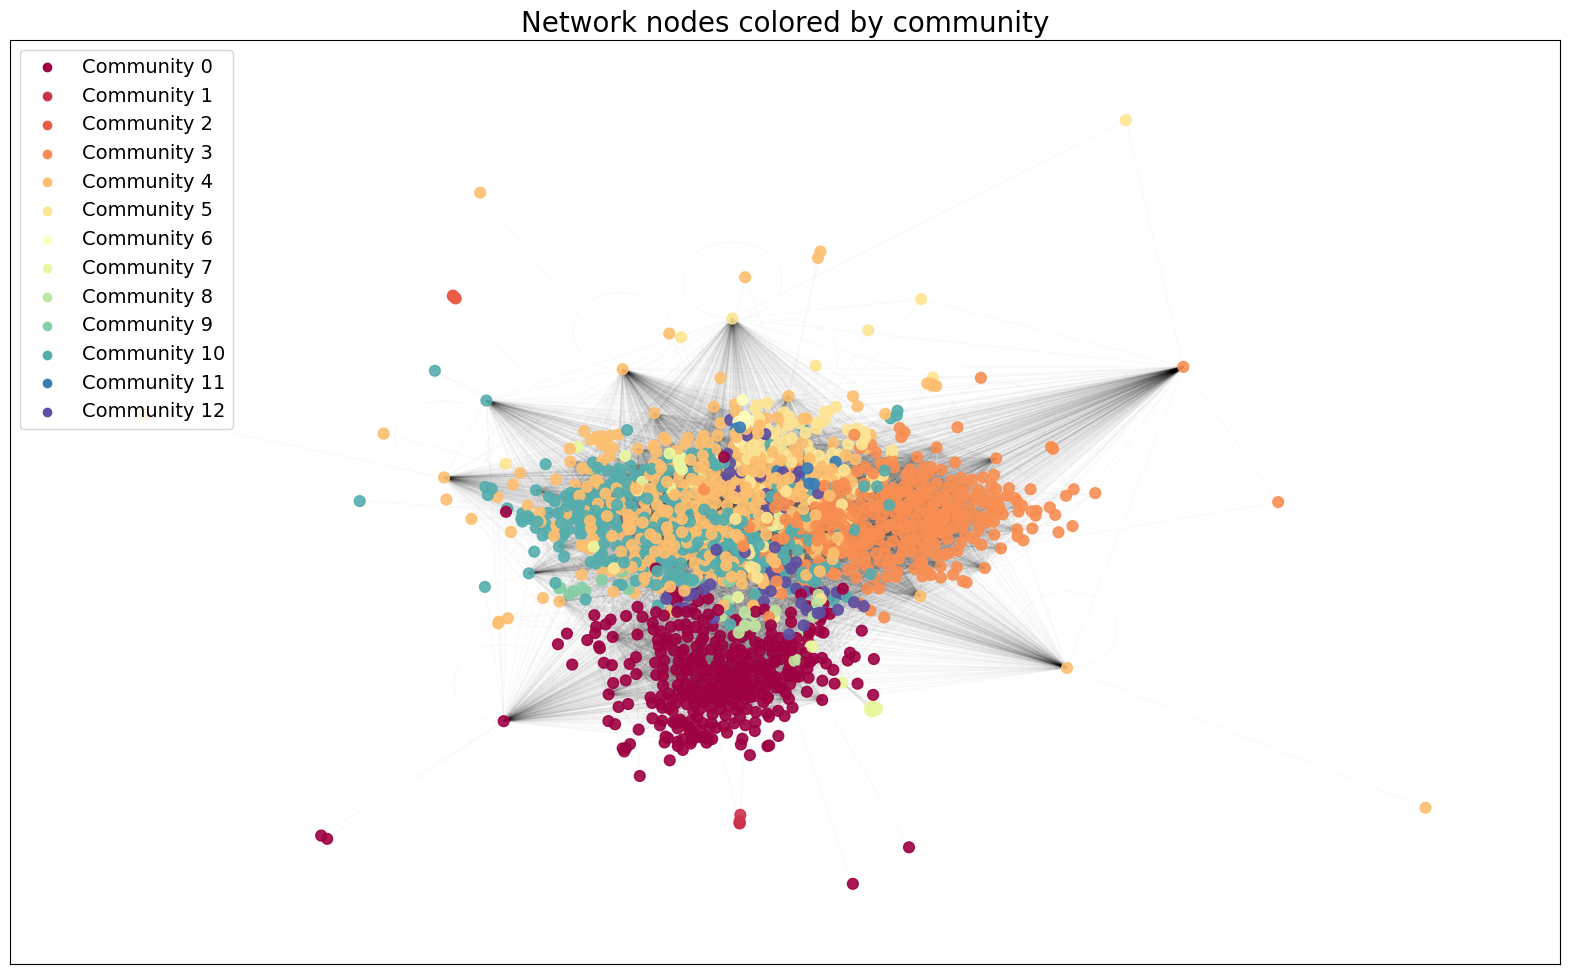

In [21]:
# drawing
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(marvel_network, pos = positions, node_color=node_color, alpha=0.9, node_size = 60); #, node_size=node_size;
nx.draw_networkx_edges(marvel_network, pos = positions, alpha=0.02);#edge_color=edge_color,

for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.show()


From the plot we now see the way the marvel universe is divided into communities. 
Worth noting is that split of the Marvel universe in two that could be seen in the Marvel universe before doing the community detection is indeed a community - here $community$ $5$. 
This community and the characters in it will be inspected later.

**For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.**

**Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.**

TF-IDF measures how important a word is for a document in a collection of documents where the word appears. It consists of a term frequency and an inverse document frequency. Term frequency is used to determine how frequent a word is in a given text, while inverse document frequency determines how much information a word provides based on it's apperance accross all the documents. The two values are multiplied for each word in a given document to provide the value of TF-IDF. 
A high value in TF-IDF shows that the word is important in describing that given text. The use of IDF makes it less important to remove stopwords since a word that appears in many texts will get a very low score in IDF. 

For the 10 largest communities we calculate and create a TF-IDF vector. For the term frequency we simply use the standard term frequency. 


In [22]:
partition = partition

#Defining stopwords and extending with wikiwords
stopwords = nltk.corpus.stopwords.words('english')
wikiwords = ['ref', 'cite', 'category', 'br', 'also','pageid', 'batchcomplete', 'query','wikitext','wikipedia','wikiproject','https','web']
stopwords.extend(wikiwords)

community_list = []
total_list = []
# Looping through partition
for i in set(partition.values()):
    # Getting names of characters in given partition
    names = [name for name,com in partition.items() if com == i]
    
    cur_list = []
    for name in names:
        links = marvel_dict[name]
        for filename in links:
            f = open(marvel_path+filename+'.txt')
            raw = f.read()
            cur_tokens = nltk.word_tokenize(raw)
            # removing all special characters in text
            cur_words = [w.lower() for w in cur_tokens if w.isalpha()]
            # adding text to that communities text file
            cur_list.extend(cur_words)
        
    #Removing stopwords before adding to list of communities
    cur_list = [word for word in cur_list if not word in stopwords]   
    community_list.append(cur_list)
    total_list.extend(cur_list)

In [23]:
# Counting how many times each word appears in the different community texts
worddictlist = []
for com in community_list: 
    worddict = dict.fromkeys(total_list,0) 
    for word in com:
        worddict[word] += 1
    worddictlist.append(worddict)
    
fq = pd.DataFrame(worddictlist)

In [24]:
def termfreq(worddict, com):
    #funtion for calculating termfrequency for all words in a community text
    tfdict = {}
    numberofwords = len(com)
    for word, count in worddict.items():
        tfdict[word] = count/float(numberofwords)
    return(tfdict)

# Calculating term frequency for all community texts
tfdictlist = []
for i in range(0, len(community_list)):
    tfdictlist.append(termfreq(worddictlist[i], community_list[i]))
tf = pd.DataFrame(tfdictlist)

In [25]:
N = len(community_list)

# Converting to 1 where word exists
bin_tf = np.where(tf>0 , 1, tf)
num_doc_present = bin_tf.sum(axis = 0)

# Calculating idf for each word in the collection of documents and saving in a dictionary
idfdict = dict.fromkeys(tf.keys(), 0)
for i,word in enumerate(tf.keys()):
    idfdict[word] = math.log10(N / (float(num_doc_present[i])+1))


In [26]:
# Calculating tfidf vector for each community text
tfidfdictlist = []
for i in range(0, len(community_list)):
    tfidf = {}
    for word, val in tfdictlist[i].items():
        tfidf[word] = val*idfdict[word]
        
    tfidfdictlist.append(tfidf)
    
tfidf = pd.DataFrame(tfidfdictlist)
#tfidf

Text(0.5, 0, 'Unknown')

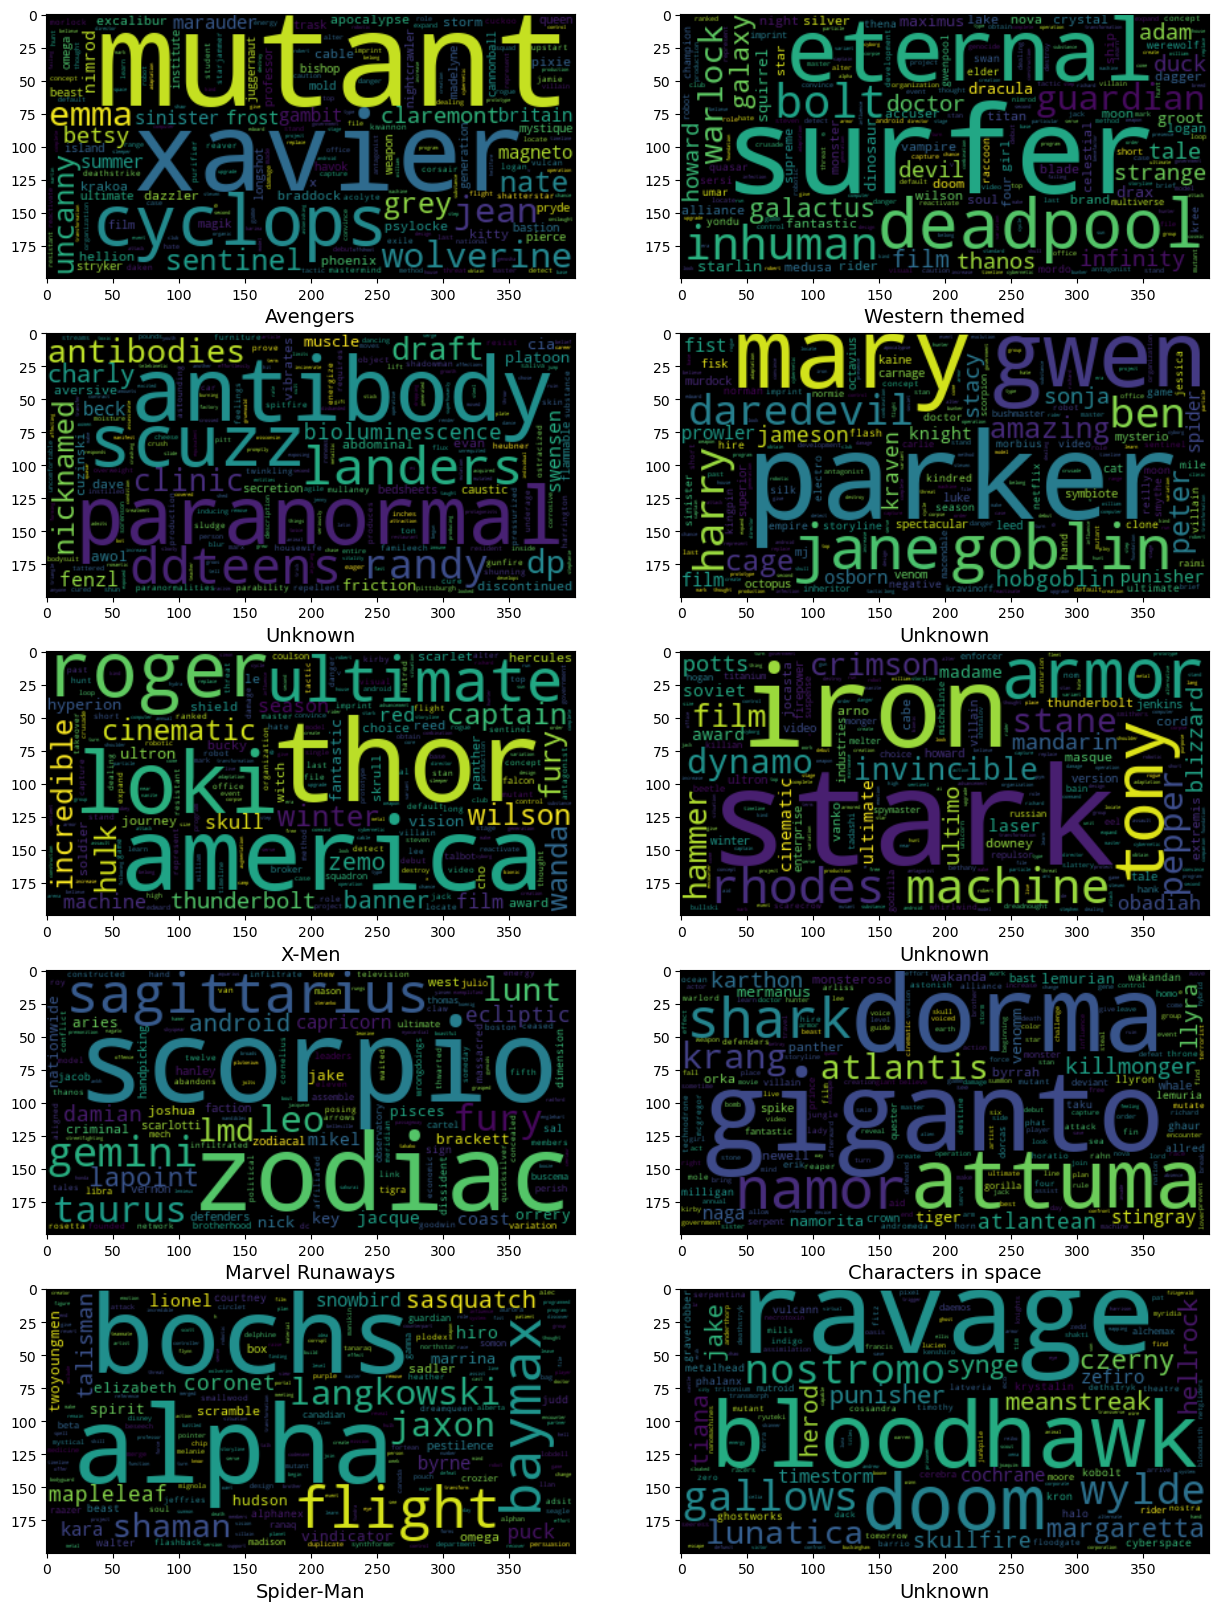

In [27]:
# Visualising the wordclouds for the 10 largest communities
list_of_wordsclouds = []
for com in tfidfdictlist:
    word_string = ''.join([(w+' ')*(math.ceil(c*10000)) for w,c in com.items()])
    #print(word_string)
    cloud = wordcloud.WordCloud(collocations = False).generate(word_string)
    list_of_wordsclouds.append(cloud)
    
fig, axs = plt.subplots(5, 2, figsize=(15, 20));
axs[0,0].imshow(list_of_wordsclouds[0], interpolation='bilinear');
axs[0,0].set_xlabel('Avengers', fontsize = 14)
axs[0,1].imshow(list_of_wordsclouds[10], interpolation='bilinear');
axs[0,1].set_xlabel('Western themed', fontsize = 14)
axs[1,0].imshow(list_of_wordsclouds[2], interpolation='bilinear');
axs[1,0].set_xlabel('Unknown', fontsize = 14)
axs[1,1].imshow(list_of_wordsclouds[3], interpolation='bilinear');
axs[1,1].set_xlabel('Unknown', fontsize = 14)
axs[2,0].imshow(list_of_wordsclouds[4], interpolation='bilinear');
axs[2,0].set_xlabel('X-Men', fontsize = 14)
axs[2,1].imshow(list_of_wordsclouds[5], interpolation='bilinear');
axs[2,1].set_xlabel('Unknown', fontsize = 14)
axs[3,0].imshow(list_of_wordsclouds[6], interpolation='bilinear');
axs[3,0].set_xlabel('Marvel Runaways', fontsize = 14)
axs[3,1].imshow(list_of_wordsclouds[7], interpolation='bilinear');
axs[3,1].set_xlabel('Characters in space', fontsize = 14)
axs[4,0].imshow(list_of_wordsclouds[8], interpolation='bilinear');
axs[4,0].set_xlabel('Spider-Man', fontsize = 14)
axs[4,1].imshow(list_of_wordsclouds[9], interpolation='bilinear');
axs[4,1].set_xlabel('Unknown', fontsize = 14)

Each wordcloud has gotten a caption explaining what the community understood as. We see some exciting connection in the communities. Both an Avengers, X-men, Western themed, Marvel Runaways, space characters and Spider-Man community is seen. 

Since some of the communities only contain very few nodes it is hard to see the connection and therefore they are marked as unknown.

Earlier we mentioned that community 5 (X-Men) seemed to be the community that split the Marvel network into two internal community almost. This makes sense since the X-Men characters are very interconnected in the comics. 

# Sentiment

**First calculate the sentiment for all character pages.**

In [28]:
# reading wordlist
path = "data/labmt.txt"
df_wordlist = pd.read_csv(path, sep='\t')

# Extracting the happpiness average from the data
wordlist = df_wordlist[['word', 'happiness_average']].set_index('word')['happiness_average'].to_dict()

In [29]:
# should implement if word not in wordlist freq
def sentiment(txt):
    union_words = []
    for i in txt:
        if i in wordlist:
            union_words.append(i)
    number_of_words = len(union_words)
    fdist = nltk.FreqDist(txt)
    sentiment = 0
    for word, count in fdist.items():
        freq = count/number_of_words
        val = 0
        if word in wordlist:
            val = wordlist[word]         
        sentiment += freq*val    
    return sentiment

In [30]:
marvel_char = marvel_char
marvel_network = UGCC.subgraph(marvel_char).copy()
nodes = max(nx.connected_components(marvel_network), key=len)
marvel_network = marvel_network.subgraph(nodes).copy()

dc_char = dc_char
dc_network = UGCC.subgraph(dc_char).copy()
nodes = max(nx.connected_components(dc_network), key=len)
dc_network = dc_network.subgraph(nodes).copy()

values = dict.fromkeys(UGCC.nodes(),0)
for name in list(marvel_network.nodes()):
    links = marvel_dict[name]
    textholder = []
    for link in links:
        f = open(marvel_path+link+'.txt')
        raw = f.read()
        cur_tokens = nltk.word_tokenize(raw)
        cur_words = [w.lower() for w in cur_tokens if w.isalpha()]
        cur_words_sw = [word for word in cur_words if not word in stopwords]
        textholder.append(sentiment(cur_words_sw))
    values[name] = np.mean(textholder) 
    
for name in list(dc_network.nodes()):
    links = dc_dict[name]
    textholder = []
    for link in links:
        f = open(dc_path+link+'.txt')
        raw = f.read()
        cur_tokens = nltk.word_tokenize(raw)
        cur_words = [w.lower() for w in cur_tokens if w.isalpha()]
        cur_words_sw = [word for word in cur_words if not word in stopwords]
        textholder.append(sentiment(cur_words_sw))
    values[name] = np.mean(textholder) 

nx.set_node_attributes(UGCC, values, name = 'Sentiment')

In [31]:
sentiment_list = list(nx.get_node_attributes(UGCC, name = 'Sentiment').items())
sorted(sentiment_list, key = lambda x: x[1], reverse = True)[:10]

[('Brimstone Love', 6.692000000000001),
 ('Free Spirit', 6.603225806451612),
 ('Happy Hogan', 6.528333333333334),
 ('Pretty Boy', 6.4781818181818185),
 ('Gardener', 6.3675),
 ('Mother Night', 6.342666666666665),
 ('Berzerker', 6.305714285714285),
 ('Litterbug', 6.305714285714285),
 ('Hope Summers', 6.298333333333334),
 ('Gentle', 6.263333333333334)]

**Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment**

In [32]:
sentiment = [value for name, value in sentiment_list]

sentiment_mean = np.mean(sentiment)
sentiment_median = np.median(sentiment)
sentiment_10per = np.percentile(sentiment, 10)
sentiment_90per = np.percentile(sentiment, 90)

print(f"Mean of sentiment: {'':<11}{sentiment_mean}")
print(f"Median of sentiment: {'':<9}{sentiment_median:<25}")
print(f"10th percentile of sentiment: {'':<0}{sentiment_10per:<25}")
print(f"90th percentile of sentiment: {'':<0}{sentiment_90per:<25}")

Mean of sentiment:            5.621728637605333
Median of sentiment:          5.625898658718332        
10th percentile of sentiment: 5.428825580260961        
90th percentile of sentiment: 5.937777777777777        


**Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.**

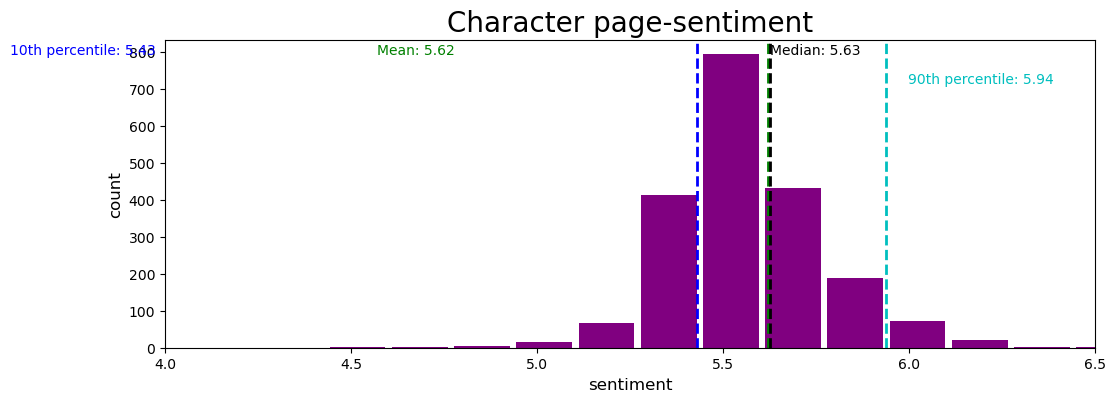

In [33]:

sentiment_hist, sentiment_bin_edges = np.histogram(sentiment, bins = 40)


fig = plt.figure(figsize=(12,4))
plt.bar(sentiment_bin_edges[:-1], sentiment_hist, align ='center', width = 0.15, color = 'purple')
plt.title('Character page-sentiment', fontsize=20)
plt.xlabel('sentiment', fontsize=12)
plt.ylabel('count', fontsize=12)


plt.axvline(sentiment_mean, color='green', linestyle='dashed', linewidth=2)
plt.text(sentiment_mean**0.88, np.max(sentiment_hist), 'Mean: {:.2f}'.format(sentiment_mean), color = 'green')

plt.axvline(sentiment_median, color='k', linestyle='dashed', linewidth=2)
plt.text(sentiment_median*1.0, np.max(sentiment_hist), 'Median: {:.2f}'.format(sentiment_median), color = 'k')

plt.axvline(sentiment_10per, color='b', linestyle='dashed', linewidth=2)
plt.text(sentiment_10per*0.66, np.max(sentiment_hist), '10th percentile: {:.2f}'.format(sentiment_10per), color = 'b')

plt.axvline(sentiment_90per, color='c', linestyle='dashed', linewidth=2)
plt.text(sentiment_90per*1.01, np.max(sentiment_hist)*0.9, '90th percentile: {:.2f}'.format(sentiment_90per), color = 'c')

plt.xlim([4, 6.5])
plt.show()


**Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.**

In [34]:
path = "data/wiki_meta_data.csv"
df_villains_heroes = pd.read_csv(path, sep=',')
good_guys = df_villains_heroes[['WikiLink', 'good']].set_index('WikiLink')['good'].to_dict()
# good_guys_test = df_villains_heroes.loc[df_villains_heroes['good'] == 1,['WikiLink', 'good']].set_index('WikiLink')['good'].to_dict()
bad_guys = df_villains_heroes[['WikiLink', 'bad']].set_index('WikiLink')['bad'].to_dict()
# bad_guys_test = df_villains_heroes.loc[df_villains_heroes['bad'] == 1,['WikiLink', 'bad']].set_index('WikiLink')['bad'].to_dict()

In [35]:
goodbad = dict.fromkeys(UGCC.nodes(),2)
for name in list(UGCC.nodes()):
    if name in good_guys:
        if good_guys[name] == 1:
            goodbad[name] = 1
        elif bad_guys[name] == 1:
            goodbad[name] = 0

nx.set_node_attributes(UGCC, goodbad, name = 'GoodBad')

In [36]:
goodbad_list = list(nx.get_node_attributes(UGCC, name = 'GoodBad').items())

heroes = [name for name,good in goodbad_list if good == 1]
villains = [name for name,good in goodbad_list if good == 0]

heroes_graph = UGCC.subgraph(heroes).copy()
villains_graph = UGCC.subgraph(villains).copy()

heroes_sentiment = [value for name, value in list(nx.get_node_attributes(heroes_graph, name = 'Sentiment').items())]
villains_sentiment = [value for name, value in list(nx.get_node_attributes(villains_graph, name = 'Sentiment').items())]

In [37]:
heroes_mean = np.mean(heroes_sentiment)
heroes_median = np.median(heroes_sentiment)
heroes_10per = np.percentile(heroes_sentiment, 10)
heroes_90per = np.percentile(heroes_sentiment, 90)

print(f"Good guys sentiment stats:")
print(f"Mean of sentiment: {'':<11}{heroes_mean}")
print(f"Median of sentiment: {'':<9}{heroes_median:<25}")
print(f"10th percentile of sentiment: {'':<0}{heroes_10per:<25}")
print(f"90th percentile of sentiment: {'':<0}{heroes_90per:<25}\n")

villains_mean = np.mean(villains_sentiment)
villains_median = np.median(villains_sentiment)
villains_10per = np.percentile(villains_sentiment, 10)
villains_90per = np.percentile(villains_sentiment, 90)

print(f"Bad guys sentiment stats:")
print(f"Mean of sentiment: {'':<11}{villains_mean}")
print(f"Median of sentiment: {'':<9}{villains_median:<25}")
print(f"10th percentile of sentiment: {'':<0}{villains_10per:<25}")
print(f"90th percentile of sentiment: {'':<0}{villains_90per:<25}")

Good guys sentiment stats:
Mean of sentiment:            5.642540985568243
Median of sentiment:          5.643581538694484        
10th percentile of sentiment: 5.480553872732128        
90th percentile of sentiment: 5.810351934617948        

Bad guys sentiment stats:
Mean of sentiment:            5.55565316772463
Median of sentiment:          5.554137055837563        
10th percentile of sentiment: 5.406452075287895        
90th percentile of sentiment: 5.701893398501785        


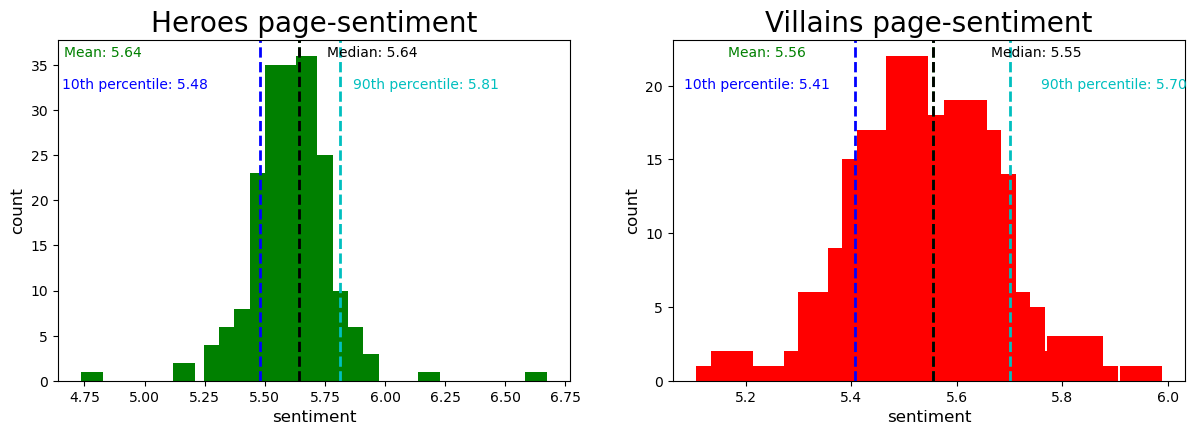

In [38]:
h_hist, h_bin_edges = np.histogram(heroes_sentiment, bins = 30)
v_hist, v_bin_edges = np.histogram(villains_sentiment, bins = 30)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('Heroes page-sentiment', fontsize = 20)
ax1.set_xlabel('sentiment', fontsize = 12)
ax1.set_ylabel('count', fontsize = 12)
ax1.bar(h_bin_edges[:-1], h_hist, align ='center', width = 0.09, color = 'green');

ax1.axvline(heroes_mean, color='green', linestyle='dashed', linewidth=2)
ax1.text(heroes_mean**0.89, np.max(h_hist), 'Mean: {:.2f}'.format(heroes_mean), color = 'green')

ax1.axvline(heroes_median, color='k', linestyle='dashed', linewidth=2)
ax1.text(heroes_median*1.02, np.max(h_hist), 'Median: {:.2f}'.format(heroes_median), color = 'k')

ax1.axvline(heroes_10per, color='b', linestyle='dashed', linewidth=2)
ax1.text(heroes_10per*0.85, np.max(h_hist)*0.9, '10th percentile: {:.2f}'.format(heroes_10per), color = 'b')

ax1.axvline(heroes_90per, color='c', linestyle='dashed', linewidth=2)
ax1.text(heroes_90per*1.01, np.max(h_hist)*0.9, '90th percentile: {:.2f}'.format(heroes_90per), color = 'c')


ax2.set_title('Villains page-sentiment', fontsize = 20)
ax2.set_xlabel('sentiment', fontsize = 12)
ax2.set_ylabel('count', fontsize = 12)
ax2.bar(v_bin_edges[:-1], v_hist, align ='center', width = 0.08, color = 'red');

ax2.axvline(villains_mean, color='green', linestyle='dashed', linewidth=2)
ax2.text(villains_mean*0.93, np.max(v_hist)*1, 'Mean: {:.2f}'.format(villains_mean), color = 'green')

ax2.axvline(villains_median, color='k', linestyle='dashed', linewidth=2)
ax2.text(villains_median*1.02, np.max(v_hist)*1, 'Median: {:.2f}'.format(villains_median), color = 'k')

ax2.axvline(villains_10per, color='b', linestyle='dashed', linewidth=2)
ax2.text(villains_10per*.94, np.max(v_hist)*0.9, '10th percentile: {:.2f}'.format(villains_10per), color = 'b')

ax2.axvline(villains_90per, color='c', linestyle='dashed', linewidth=2)
ax2.text(villains_90per*1.01, np.max(v_hist)*0.9, '90th percentile: {:.2f}'.format(villains_90per), color = 'c')

plt.subplots_adjust(wspace = 0.2)

### label permutation test

* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.


In [39]:
average_marvel_centroid = np.mean(list(nx.degree_centrality(marvel_network).values()))
average_dc_centroid = np.mean(list(nx.degree_centrality(dc_network).values()))
average_general_centroid = np.mean(list(nx.degree_centrality(UGCC).values()))
print(f'Average degree centrality for Marvel: {average_marvel_centroid}')
print(f'Average degree centrality for DC: {average_dc_centroid}')
print(f'Average degree centrality for general: {average_general_centroid}')

Average degree centrality for Marvel: 0.014166152267498257
Average degree centrality for DC: 0.036675299820055955
Average degree centrality for general: 0.01077498689871181


In [40]:
random_good_sentiment_average = []
random_bad_sentiment_average = []
random_selection_sentiment_average = []
for i in range(1000):
    random_char_selection = np.random.permutation(np.random.choice(df_villains_heroes['CharacterName'],100))
    random_heroes_sentiment = np.random.choice(heroes_sentiment,100)
    random_villains_sentiment = np.random.choice(villains_sentiment,100)
    random_char_sentiment = [value for name, value in list(nx.get_node_attributes(UGCC, name = 'Sentiment').items()) if name in random_char_selection]
    random_good_sentiment_average.append(np.mean(random_heroes_sentiment))
    random_bad_sentiment_average.append(np.mean(random_villains_sentiment))
    random_selection_sentiment_average.append(np.mean(random_char_sentiment))

print(f'Average sentiment for random heroes: {np.mean(random_good_sentiment_average)}')
print(f'Average sentiment for random villains: {np.mean(random_bad_sentiment_average)}')
print(f'Average sentiment for random characters: {np.mean(random_selection_sentiment_average)}')

Average sentiment for random heroes: 5.642011879852258
Average sentiment for random villains: 5.555694357501059
Average sentiment for random characters: 5.613538356843333


We can see that in 1000 permutations we get that the average sentiment for heroes (good guys) is above the average sentiment for randomly selected characters, who in turn have a higher sentiment than villains (bad guys). This overall shows that the good guys have overall a greater positive sentiment and that bad guys have an overall smaller sentiment.